<a href="https://colab.research.google.com/github/thanawutth/TimeSeries/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series ข้อมูลอนุกรมเวลาที่อ้างอิงตามเวลา**
สิ่งที่น่าสนใจ
- แนวโน้ม (Trends)
- แปรตามฤดูกาล (Seasonlity)
- วัฏจักร (Cycle)

**เพื่อนำไปพยากรณ์ (Forecasting)**

**Forecasting PM2.5 ในเชียงราย**
Regression : LightGBM regressor

แหล่งข้อมูล : https://aqicn.org/data-platform/register/

เรียกใช้ API package ที่จำเป็น 

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 10)

In [2]:
data_url = 'https://raw.githubusercontent.com/thanawutth/TimeSeries/main/ChiangRai-Hospital.csv'
data = pd.read_csv(data_url, parse_dates=['date'], na_values=[' '], skipinitialspace=True)
data

,date,pm25,pm10
0,2022-07-01,15.0,5.0
1,2022-07-02,18.0,NaN
2,2022-07-04,17.0,NaN
3,2022-07-07,21.0,NaN
4,2022-07-11,21.0,NaN
...,...,...,...
568,2019-06-23,NaN,11.0
569,2019-06-29,NaN,6.0
570,2019-02-28,NaN,38.0
571,2019-03-26,NaN,84.0


In [3]:
data=data.sort_values('date').reset_index(drop=True).copy()
data

,date,pm25,pm10
0,2019-02-28,NaN,38.0
1,2019-03-01,111.0,54.0
2,2019-03-02,149.0,53.0
3,2019-03-03,145.0,49.0
4,2019-03-04,138.0,35.0
...,...,...,...
568,2022-07-07,21.0,NaN
569,2022-07-10,NaN,6.0
570,2022-07-11,21.0,NaN
571,2022-07-12,NaN,6.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    573 non-null    datetime64[ns]
 1   pm25    524 non-null    float64       
 2   pm10    524 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 13.6 KB


**หากทดลองใช้ data.info() พบว่า มี missing data สำหรับบางวัน**

In [5]:
y_col='pm25'
data.dropna(subset=[y_col], inplace=True)
data=data.reset_index(drop=True)
data

,date,pm25,pm10
0,2019-03-01,111.0,54.0
1,2019-03-02,149.0,53.0
2,2019-03-03,145.0,49.0
3,2019-03-04,138.0,35.0
4,2019-03-05,102.0,32.0
...,...,...,...
519,2022-07-02,18.0,NaN
520,2022-07-04,17.0,NaN
521,2022-07-07,21.0,NaN
522,2022-07-11,21.0,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    524 non-null    datetime64[ns]
 1   pm25    524 non-null    float64       
 2   pm10    475 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 12.4 KB


**แยกส่วน วัน เดือน ปี  เพื่อนำไปเป็น feature สำหรับการเรียนรู้ที่ข้อมูลที่เป็น Time series forecasting**

**def date_parts(data, date_colname='date'):**

In [7]:
def date_parts(data, date_colname='date'):
    '''create year, month, day, dayname columns'''
    data['year']=data['date'].dt.year
    data['month']=data['date'].dt.month
    data['day']=data['date'].dt.day
    data['day_name']=data['date'].dt.day_name().astype('category')

In [8]:
date_parts(data)
data

,date,pm25,pm10,year,month,day,day_name
0,2019-03-01,111.0,54.0,2019,3,1,Friday
1,2019-03-02,149.0,53.0,2019,3,2,Saturday
2,2019-03-03,145.0,49.0,2019,3,3,Sunday
3,2019-03-04,138.0,35.0,2019,3,4,Monday
4,2019-03-05,102.0,32.0,2019,3,5,Tuesday
...,...,...,...,...,...,...,...
519,2022-07-02,18.0,NaN,2022,7,2,Saturday
520,2022-07-04,17.0,NaN,2022,7,4,Monday
521,2022-07-07,21.0,NaN,2022,7,7,Thursday
522,2022-07-11,21.0,NaN,2022,7,11,Monday


In [9]:
data.columns

Index(['date', 'pm25', 'pm10', 'year', 'month', 'day', 'day_name'], dtype='object')

In [10]:
df=data[['date', 'year', 'month', 'day', 'day_name', y_col]]
df

,date,year,month,day,day_name,pm25
0,2019-03-01,2019,3,1,Friday,111.0
1,2019-03-02,2019,3,2,Saturday,149.0
2,2019-03-03,2019,3,3,Sunday,145.0
3,2019-03-04,2019,3,4,Monday,138.0
4,2019-03-05,2019,3,5,Tuesday,102.0
...,...,...,...,...,...,...
519,2022-07-02,2022,7,2,Saturday,18.0
520,2022-07-04,2022,7,4,Monday,17.0
521,2022-07-07,2022,7,7,Thursday,21.0
522,2022-07-11,2022,7,11,Monday,21.0


In [11]:
df=df.set_index('date')
df

,year,month,day,day_name,pm25
date,,,,,
2019-03-01,2019,3,1,Friday,111.0
2019-03-02,2019,3,2,Saturday,149.0
2019-03-03,2019,3,3,Sunday,145.0
2019-03-04,2019,3,4,Monday,138.0
2019-03-05,2019,3,5,Tuesday,102.0
...,...,...,...,...,...
2022-07-02,2022,7,2,Saturday,18.0
2022-07-04,2022,7,4,Monday,17.0
2022-07-07,2022,7,7,Thursday,21.0


กำหนดให้ date ถูกใช้เป็น index แทนที่จะเป็น ตัวเลขลำดับ ใน column แรก

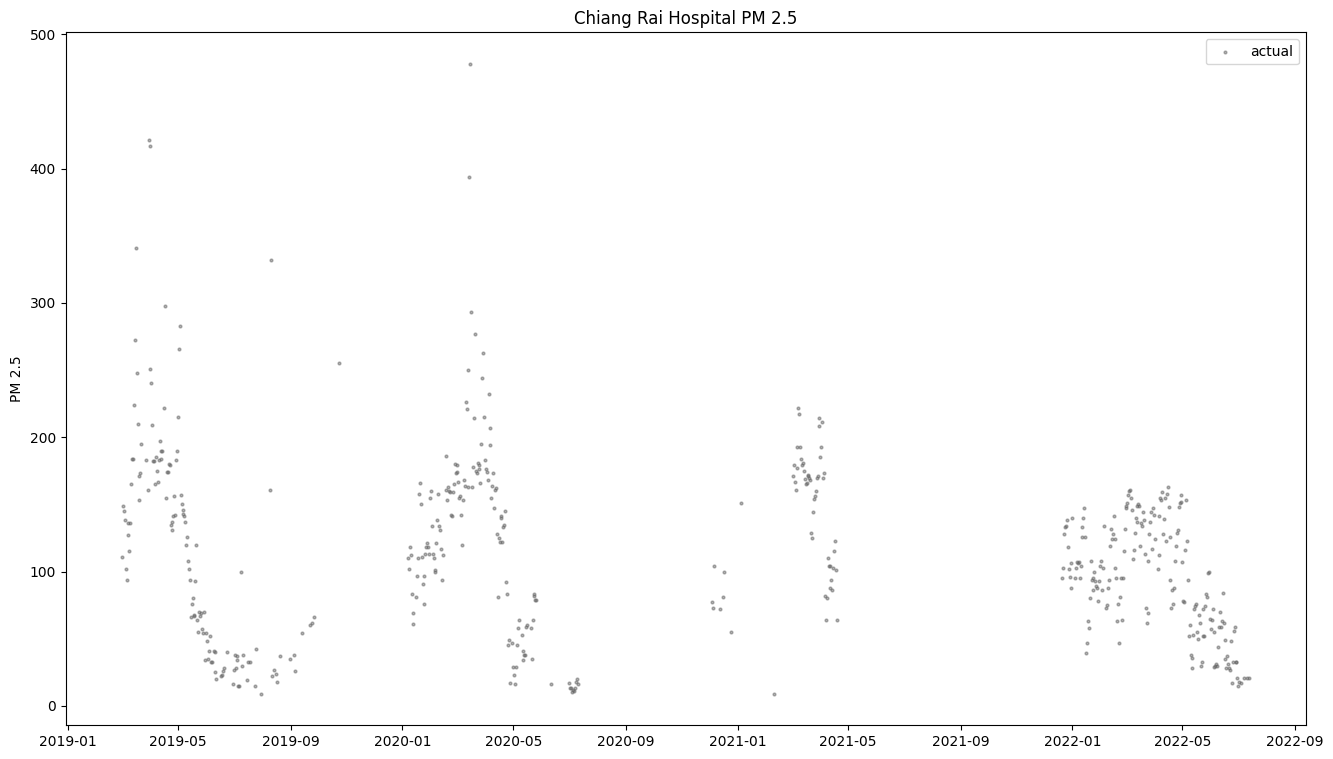

In [12]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=4, label='actual', color='.4')
plt.ylabel('PM 2.5')
plt.title('Chiang Rai Hospital PM 2.5')
plt.legend();

## **ติดตั้ง API สำหรับการพยากรณ์**
**lightgbm regressor**

lightGBM doc: https://lightgbm.readthedocs.io/en/latest/

LGBMRegressor: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

how to install lightgbm

pip: pip install -U lightgbm

conda: conda install lightgbm **bold text**

## #install python packages to run this notebook 
# !pip install -q rasterio rasterstats geopandas lightgbm 

In [13]:
# !pip install -q lightgbm

In [14]:
import lightgbm as lgb
print(f'lightgbm version = {lgb.__version__}')

lightgbm version = 3.3.5


**กำหนด Feature สำหรับการเข้าสู่กระบวนการ วิเคราะห์ข้อมูล**

In [15]:
feature_cols=[
    'year', 'month', 
    'day', 
    'day_name'
]
X=df[feature_cols]
y=df[y_col]

### **การแบ่งข้อมูล**
ให้ดูจำนวนข้อมูลทั้งหมดที่มี
ในตัวอย่างมีประมาณ 500 เรคอร์ด 
แบ่งที่ 70 เปอร์เซ็นต์ 
จึงกำหนดค่า split ที่ตำแหน่ง 350

In [16]:
split_at=350
X_train, X_test, y_train, y_test=X[:split_at], X[split_at:], y[:split_at], y[split_at:]

In [17]:
reg = lgb.LGBMRegressor()
reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### แสดง พารามิเตอร์ ของ class lightgbm

### ทดลองเรียนรู้ข้อมูลจำนวน 200 รอบ , แสดงทุกๆ 10 รอบ

In [18]:
fit_params={'early_stopping_rounds':200, 
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }
reg.fit(X_train, y_train, **fit_params)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict i

[10]	valid_0's l2: 1160.23
[20]	valid_0's l2: 1153.09
[30]	valid_0's l2: 1340.35
[40]	valid_0's l2: 1391.96
[50]	valid_0's l2: 1432.72
[60]	valid_0's l2: 1509.36
[70]	valid_0's l2: 1594.25
[80]	valid_0's l2: 1645.09
[90]	valid_0's l2: 1670.32
[100]	valid_0's l2: 1693.79


LGBMRegressor()

In [19]:
reg.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': 'warn',
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x7fce95691790>,
 '_evals_result': {'valid_0': OrderedDict([('l2',
                [2392.9197264720715,
                 2055.866005405987,
                 1784.0245755406797,
                 1616.8276085342477,
                 1475.0067739854824,
                 1381.0864395917959,
                 1303.8298057541047,
                 1251.2099185339061,
                 1174.3447342076781,
                 1160.230391175963,
                 1122.4376508221515,
                 1090.495515464722,
                 1067.91

ดูคะแนนความแม่นยำ เป็นค่า R^2

In [20]:
reg.score(X_train, y_train)

0.6265581097411163

### ทดลอง predict กับข้อมูลทดสอบ 5 ข้อมูลแรก

In [21]:
reg.predict(X_test[:5])

array([110.34507304, 110.34507304, 110.34507304, 110.34507304,
       110.34507304])

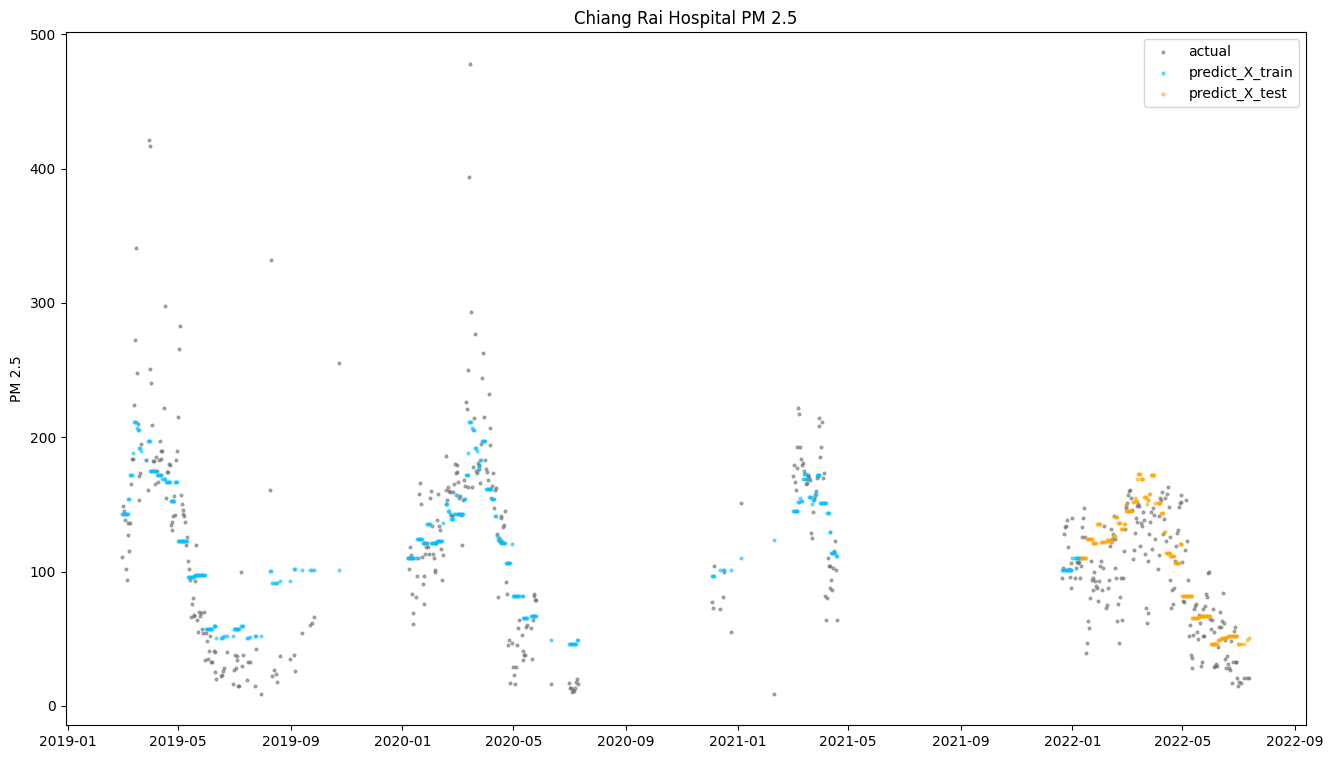

In [22]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=4, label='actual', color='.4')
plt.scatter(X_train.index, reg.predict(X_train), alpha=.5, s=4, label='predict_X_train', color='deepskyblue')
plt.scatter(X_test.index, reg.predict(X_test), alpha=.5, s=4, label='predict_X_test', color='orange')
plt.ylabel('PM 2.5')
plt.title('Chiang Rai Hospital PM 2.5')
plt.legend();

In [23]:
df

,year,month,day,day_name,pm25
date,,,,,
2019-03-01,2019,3,1,Friday,111.0
2019-03-02,2019,3,2,Saturday,149.0
2019-03-03,2019,3,3,Sunday,145.0
2019-03-04,2019,3,4,Monday,138.0
2019-03-05,2019,3,5,Tuesday,102.0
...,...,...,...,...,...
2022-07-02,2022,7,2,Saturday,18.0
2022-07-04,2022,7,4,Monday,17.0
2022-07-07,2022,7,7,Thursday,21.0


## SHAP : SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model


# !pip install shap

In [27]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 6.4 MB/s eta 0:00:00


In [29]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [30]:
X

,year,month,day,day_name
date,,,,
2019-03-01,2019,3,1,Friday
2019-03-02,2019,3,2,Saturday
2019-03-03,2019,3,3,Sunday
2019-03-04,2019,3,4,Monday
2019-03-05,2019,3,5,Tuesday
...,...,...,...,...
2022-07-02,2022,7,2,Saturday
2022-07-04,2022,7,4,Monday
2022-07-07,2022,7,7,Thursday


### วิเคราะห์แต่ละปัจจัยที่มีผลต่อ   PM2.5 ด้วย SHAP

In [31]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X)
# shap_values = explainer.shap_values(X.loc[['2021-03-04']])
# shap_values = explainer.shap_values(np.array([[2016,3,17,6]]))


In [32]:
shap_values

array([[  4.82374961,  31.18346424, -18.23855951,   0.        ],
       [  4.82374961,  31.18346424, -18.23855951,   0.        ],
       [  4.82374961,  31.18346424, -18.23855951,   0.        ],
       ...,
       [ -7.64086354, -69.80455521,  -1.55085285,   0.        ],
       [ -8.5171583 , -68.08251682,   0.32587897,   0.        ],
       [ -6.15141115, -67.63130574,  -0.71766766,   0.        ]])

In [33]:
shap_values.shape

(524, 4)

In [34]:
explainer.__dict__

{'model': <shap.explainers._tree.TreeEnsemble at 0x7fcde25b8bb0>,
 'output_names': None,
 'feature_names': None,
 'masker': None,
 'link': CPUDispatcher(<function identity at 0x7fce8994fb80>),
 'linearize_link': True,
 'data': None,
 'data_missing': None,
 'feature_perturbation': 'tree_path_dependent',
 'expected_value': 125.02285713615538,
 'model_output': 'raw',
 'approximate': False}

In [35]:
reg.predict(X_train).mean() # explainer.expected_value

125.02285713615537

### จัดข้อมูลที่เป็น โมเดลของการเรียนรู้ ให้อยู่ในรูปแบบ data frame

In [36]:
feature_cols

['year', 'month', 'day', 'day_name']

In [37]:
dshap = pd.DataFrame(shap_values, columns=feature_cols)
dshap

,year,month,day,day_name
0,4.823750,31.183464,-18.238560,0.0
1,4.823750,31.183464,-18.238560,0.0
2,4.823750,31.183464,-18.238560,0.0
3,4.823750,31.183464,-18.238560,0.0
4,4.823750,31.183464,-18.238560,0.0
...,...,...,...,...
519,-7.640864,-69.804555,-1.550853,0.0
520,-7.640864,-69.804555,-1.550853,0.0
521,-7.640864,-69.804555,-1.550853,0.0
522,-8.517158,-68.082517,0.325879,0.0


### ค่าเฉลี่ยในแต่ละปัจจัยที่มีผลกระทบต่อค่า PM2.5

In [38]:
np.abs(dshap).mean().sort_values(ascending=False)

month       34.357661
year         8.715635
day          5.371226
day_name     0.000000
dtype: float64

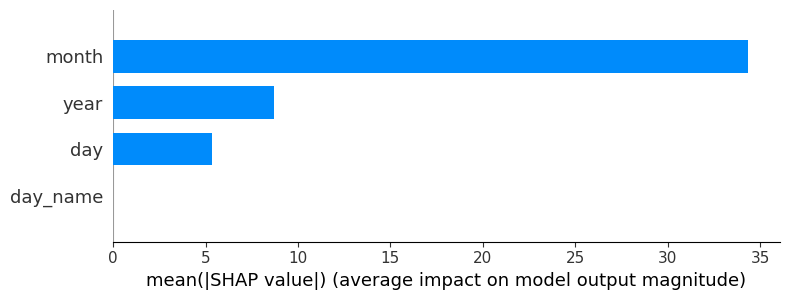

In [39]:
shap.summary_plot(shap_values, X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


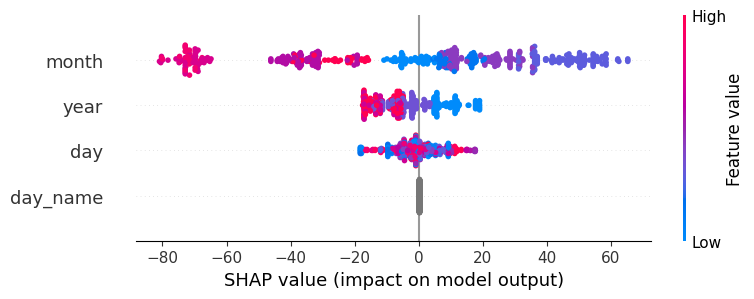

In [40]:
shap.summary_plot(shap_values, X)

In [41]:
explainer.shap_values(X)

array([[  4.82374961,  31.18346424, -18.23855951,   0.        ],
       [  4.82374961,  31.18346424, -18.23855951,   0.        ],
       [  4.82374961,  31.18346424, -18.23855951,   0.        ],
       ...,
       [ -7.64086354, -69.80455521,  -1.55085285,   0.        ],
       [ -8.5171583 , -68.08251682,   0.32587897,   0.        ],
       [ -6.15141115, -67.63130574,  -0.71766766,   0.        ]])

### การดูผลการวิเคราะห์เป็นรายกรณี

In [42]:
def individual_case_plot(explainer, X, case_index):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
    shap_values = explainer.shap_values(X.iloc[[case_index]])
    g = shap.force_plot(explainer.expected_value, shap_values=shap_values, features=X.iloc[case_index, :], matplotlib=True)
    return g

In [43]:
X.iloc[[10]]

,year,month,day,day_name
date,,,,
2019-03-11,2019,3,11,Monday


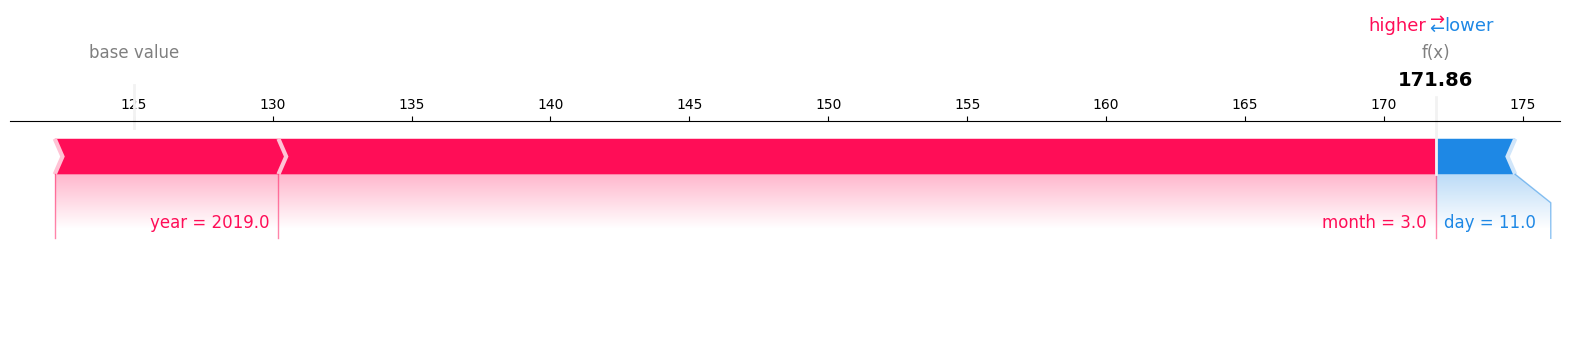

In [44]:
shap.initjs()
individual_case_plot(explainer, X, 10)

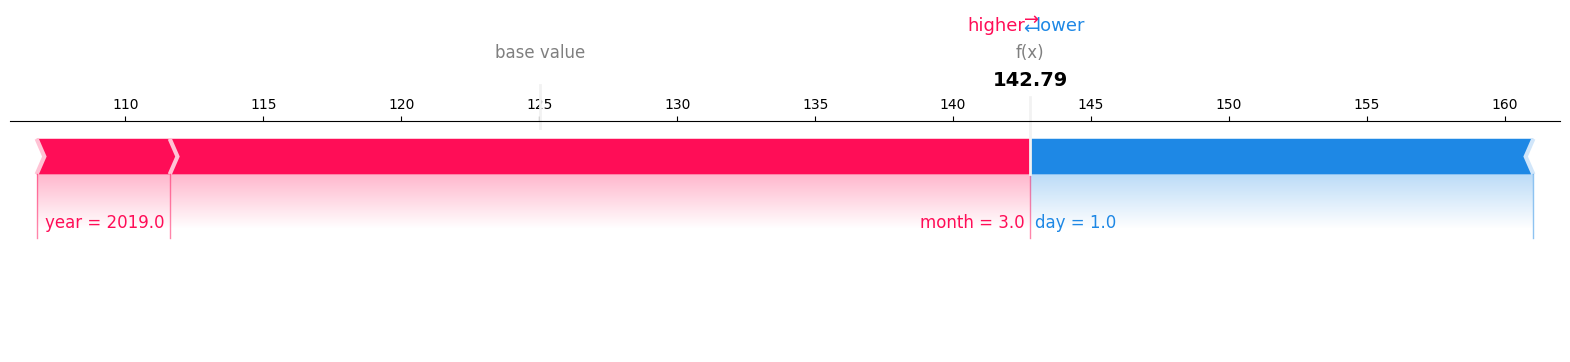

In [45]:
shap.initjs()
g=individual_case_plot(explainer, X, 0)
g

In [46]:
explainer.shap_values(X.iloc[[10]])

array([[ 8.05361635, 41.65755827, -2.8712289 ,  0.        ]])

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:365], X[:365])

In [48]:
print(y_test)


date
2022-01-10    104.0
2022-01-11    126.0
2022-01-12    133.0
2022-01-13    140.0
2022-01-14    147.0
              ...  
2022-07-02     18.0
2022-07-04     17.0
2022-07-07     21.0
2022-07-11     21.0
2022-07-13     21.0
Name: pm25, Length: 174, dtype: float64


In [49]:
print(X_test)

            year  month  day   day_name
date                                   
2022-01-10  2022      1   10     Monday
2022-01-11  2022      1   11    Tuesday
2022-01-12  2022      1   12  Wednesday
2022-01-13  2022      1   13   Thursday
2022-01-14  2022      1   14     Friday
...          ...    ...  ...        ...
2022-07-02  2022      7    2   Saturday
2022-07-04  2022      7    4     Monday
2022-07-07  2022      7    7   Thursday
2022-07-11  2022      7   11     Monday
2022-07-13  2022      7   13  Wednesday

[174 rows x 4 columns]


In [50]:
print(X_test[:10])

            year  month  day   day_name
date                                   
2022-01-10  2022      1   10     Monday
2022-01-11  2022      1   11    Tuesday
2022-01-12  2022      1   12  Wednesday
2022-01-13  2022      1   13   Thursday
2022-01-14  2022      1   14     Friday
2022-01-15  2022      1   15   Saturday
2022-01-16  2022      1   16     Sunday
2022-01-17  2022      1   17     Monday
2022-01-18  2022      1   18    Tuesday
2022-01-19  2022      1   19  Wednesday


In [51]:
reg.predict(X_test[:10])

array([110.34507304, 110.34507304, 110.34507304, 110.34507304,
       110.34507304, 110.34507304, 110.34507304, 124.44844289,
       124.44844289, 124.44844289])

In [52]:
X_test.iloc[10]

year            2022
month              1
day               20
day_name    Thursday
Name: 2022-01-20 00:00:00, dtype: object

In [53]:
idf = pd.DataFrame({'date': {0: '2023-02-20', 1: '2023-04-10', 3: '2023-04-11'}})
idf['date']=pd.to_datetime(idf['date'].astype(str), format='%Y-%m-%d')
idf.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 3
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 48.0 bytes


In [54]:
date_parts(idf)
idf

,date,year,month,day,day_name
0,2023-02-20,2023,2,20,Monday
1,2023-04-10,2023,4,10,Monday
3,2023-04-11,2023,4,11,Tuesday


In [55]:
idf=idf.set_index('date')
idf.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3 entries, 2023-02-20 to 2023-04-11
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   year      3 non-null      int64   
 1   month     3 non-null      int64   
 2   day       3 non-null      int64   
 3   day_name  3 non-null      category
dtypes: category(1), int64(3)
memory usage: 223.0 bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174 entries, 2022-01-10 to 2022-07-13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   year      174 non-null    int64   
 1   month     174 non-null    int64   
 2   day       174 non-null    int64   
 3   day_name  174 non-null    category
dtypes: category(1), int64(3)
memory usage: 6.0 KB


In [56]:
reg.predict(idf[:])

array([135.77194101, 143.46910445, 129.19053351])

### การใช้ Machine Learning เบื้องต้น ด้วย Multiple Linear Regression 

An Introduction to Statistical Learning with Applications in R (ISLR)
"An Introduction to Statistical Learning, with applications in R" (Springer, 2013) with permission from the authors: G. James, D. Witten, T. Hastie and R. Tibshirani"

https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/6009dd9fa7bc363aa822d2c7/1611259312432/ISLR+Seventh+Printing.pdf


Data Source : https://trevorhastie.github.io/ISLR/data.html


In [61]:
import seaborn as sns

In [62]:
url = 'https://raw.githubusercontent.com/thanawutth/TimeSeries/main/Advertising.csv'
df=pd.read_csv(url, usecols=[1, 2, 3, 4])
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


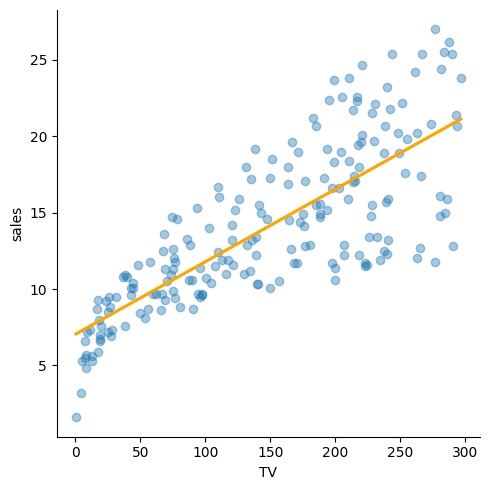

In [68]:
sns.lmplot(x='TV', y='sales', data=df, ci=None, scatter_kws={'alpha': 0.4}, 
           line_kws={'color': 'orange'})

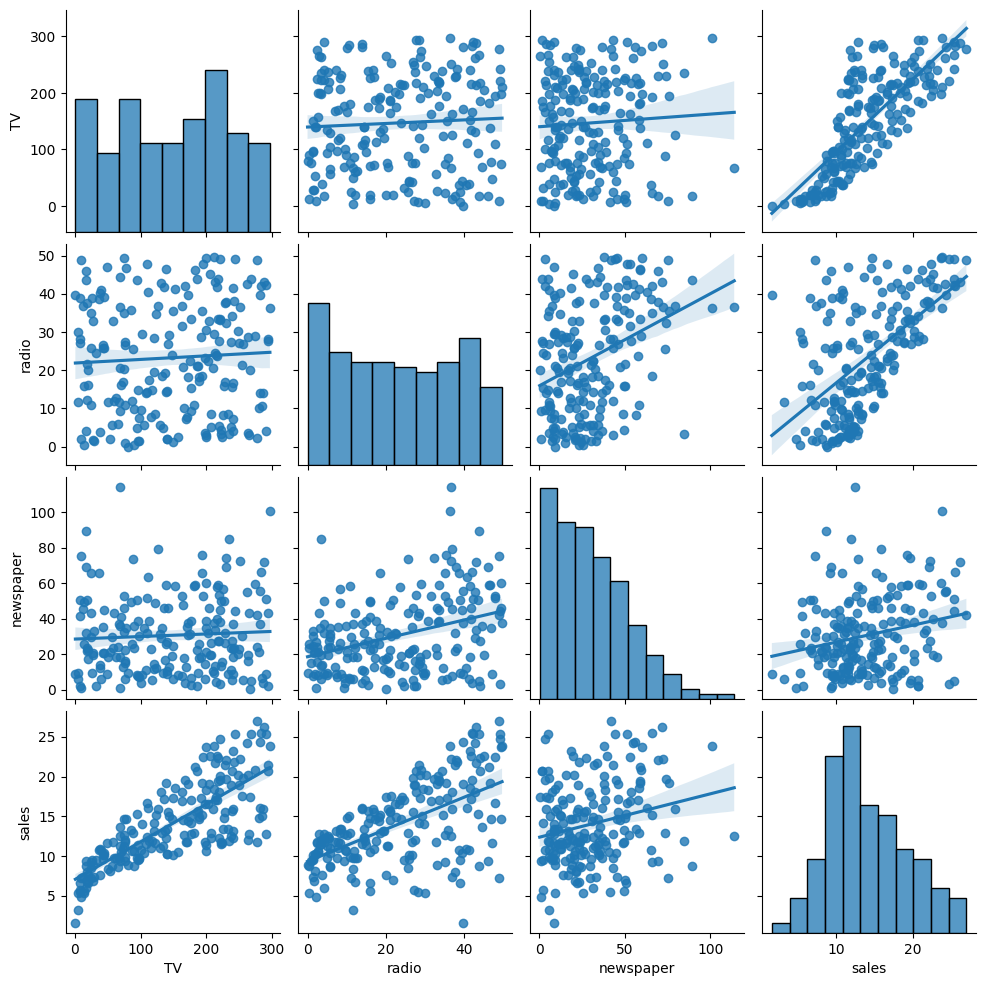

In [69]:
sns.pairplot(df, kind='reg');

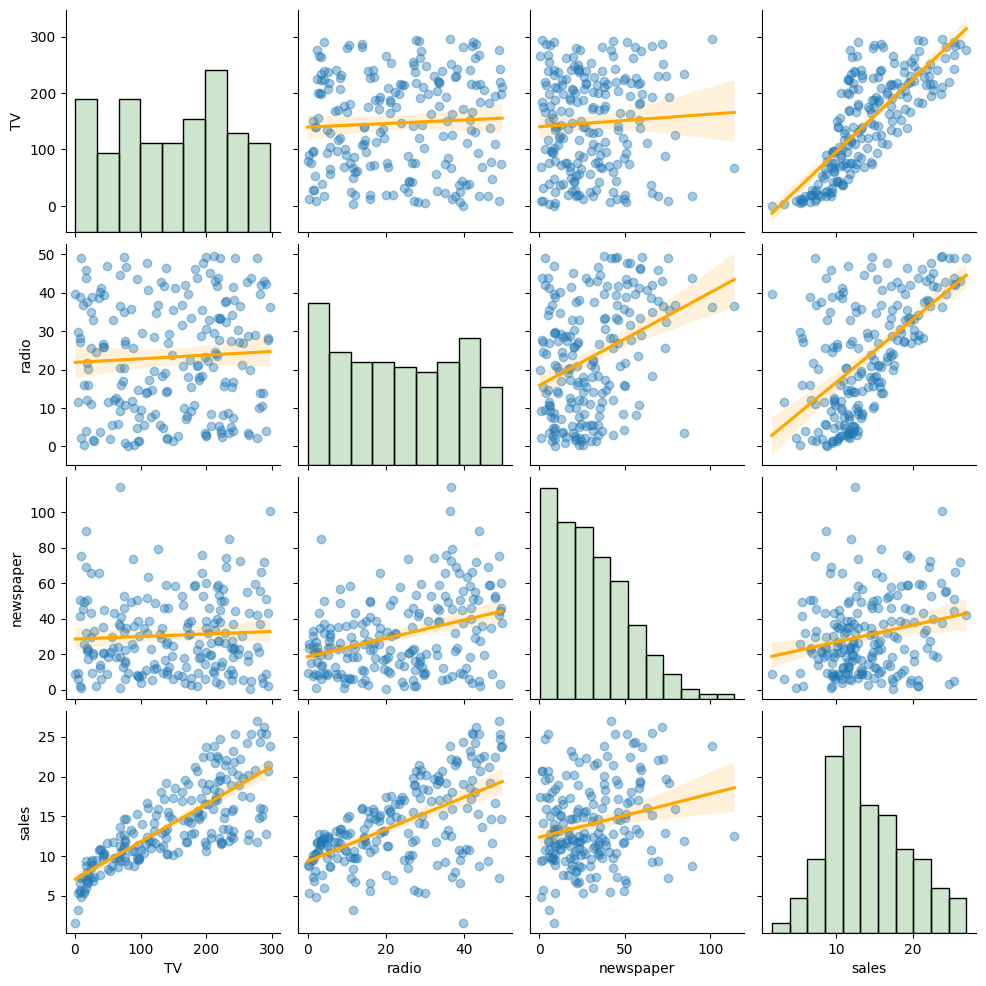

In [70]:
sns.pairplot(df,
             kind='reg', 
             plot_kws={'scatter_kws': {'alpha': 0.4}, 
                       'line_kws': {'color': 'orange'}},
             diag_kws={'color': 'green', 'alpha':.2});

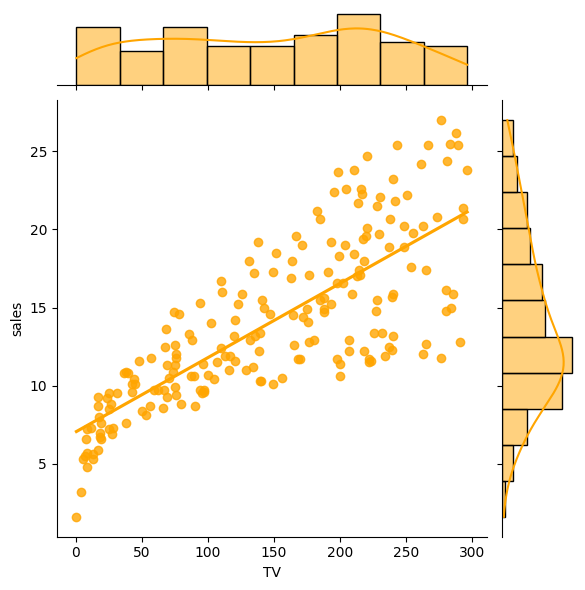

In [72]:
sns.jointplot(x='TV', y='sales', data=df, kind='reg', ci=None,
              color='orange');

In [73]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model

LinearRegression()

In [75]:
len(df)

200

In [76]:
df.columns

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

In [77]:
X=df.drop(columns=['sales'])[:140]
y=df['sales'][:140]

In [78]:
model.fit(X, y)

LinearRegression()

In [79]:
model.score(X, y) # R-squared

0.8937102367013778

In [80]:
model.intercept_

3.0451422090371167

In [81]:
model.coef_

array([ 0.04704868,  0.17968299, -0.00300557])

## ทำนาย ยอดขายจาก input ที่อยากทำนาย

In [82]:
model.predict([[200, 40, 70]])

X does not have valid feature names, but LinearRegression was fitted with feature names


array([19.43180837])

In [83]:
model.predict([[200, 40, 70], 
               [100, 80, 50],
               [ 40, 20, 10]])

X does not have valid feature names, but LinearRegression was fitted with feature names


array([19.43180837, 21.97437115,  8.49069357])

In [84]:
X_test=df.drop(columns=['sales'])[140:]
X_test.head()

,TV,radio,newspaper
140,73.4,17.0,12.9
141,193.7,35.4,75.6
142,220.5,33.2,37.9
143,104.6,5.7,34.4
144,96.2,14.8,38.9


In [85]:
y_hat=model.predict(X_test)
y_hat

array([ 9.5143544 , 18.29202877, 19.27094064,  8.88723582, 10.11361706,
        9.96041972, 15.62706788, 23.1587013 , 12.03845031,  9.72212471,
       18.63809455, 10.10099867, 16.48589616, 18.12468609, 15.64364266,
        5.30523275, 15.12744231, 10.25358725, 10.09006252, 12.44362791,
       14.3210309 , 13.3616908 , 15.08443331, 17.32769433, 11.18435749,
       14.4341081 , 10.57847377, 13.65085298, 17.24682604, 18.30648623,
        7.42659652, 14.39756088,  7.52782982, 12.20541805, 14.08031808,
       24.73378746, 20.09744782, 12.3485591 , 16.40555117, 12.5803357 ,
       10.85519521, 14.21321462,  6.62420582, 24.08691176, 18.72317811,
       20.7349155 ,  9.90581943, 17.13834561, 18.98753788,  6.02878648,
       12.27110367,  8.5198605 ,  4.49610391, 18.42872767, 16.46701074,
        5.46575208,  8.33322951, 13.02457489, 23.73586521, 15.48426632])

In [86]:
dc=pd.concat([df[140:].reset_index(), pd.Series(y_hat, name='predicted')], axis='columns')
dc

,index,TV,radio,newspaper,sales,predicted
0,140,73.4,17.0,12.9,10.9,9.514354
1,141,193.7,35.4,75.6,19.2,18.292029
2,142,220.5,33.2,37.9,20.1,19.270941
3,143,104.6,5.7,34.4,10.4,8.887236
4,144,96.2,14.8,38.9,11.4,10.113617
...,...,...,...,...,...,...
55,195,38.2,3.7,13.8,7.6,5.465752
56,196,94.2,4.9,8.1,9.7,8.333230
57,197,177.0,9.3,6.4,12.8,13.024575
58,198,283.6,42.0,66.2,25.5,23.735865


## **Statsmodels: Multiple Linear regression**

In [90]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [92]:
model_a = smf.ols(formula='sales ~ TV + radio + newspaper', data=df[:140]).fit()

In [93]:
print(model_a.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     381.2
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           5.60e-66
Time:                        14:21:46   Log-Likelihood:                -273.89
No. Observations:                 140   AIC:                             555.8
Df Residuals:                     136   BIC:                             567.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0451      0.391      7.782      0.0

In [94]:
ya_hat=model_a.predict(X_test)

In [95]:
ya_hat.head()

140     9.514354
141    18.292029
142    19.270941
143     8.887236
144    10.113617
dtype: float64

In [96]:
y_hat[:5]

array([ 9.5143544 , 18.29202877, 19.27094064,  8.88723582, 10.11361706])

***### เอกสารประกอบการ ทั้งหมดจาก ***
## author: Prasert Kanawattanachai

## e-mail: prasert.k@chula.ac.th